In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
import pickle

- Data is stored in a nested structure
- Two parent folders, one for phone data, and one for watch data
- Inside each are two more folders, one for accelerometer data, one for gyroscope data


# Naming Conventions:
- a = accelerometer
- g = gryoscope
- w = watch
- p = phone
- X = independent variable
- Y = dependent variable, targets

In [6]:
#Path Names
participant_id = list(range(1600,1651))

#Initialize empty lists for each pathname
accel_phone = []
gyro_phone = []
accel_watch = []
gyro_watch = []

for i in participant_id:
    accel_phone.append(f"../Accelerometer-Action-Dectection/wisdm-dataset/raw/phone/accel/data_{i}_accel_phone.txt")
    gyro_phone.append(f"../Accelerometer-Action-Dectection/wisdm-dataset/raw/phone/gyro/data_{i}_gyro_phone.txt")
    accel_watch.append(f"../Accelerometer-Action-Dectection/wisdm-dataset/raw/watch/accel/data_{i}_accel_watch.txt")
    gyro_watch.append(f"../Accelerometer-Action-Dectection/wisdm-dataset/raw/watch/gyro/data_{i}_gyro_watch.txt")
    
#Check to see it worked
print(accel_phone[10])
print(gyro_phone[10])
print(accel_watch[10])
print(gyro_watch[10])

../Accelerometer-Action-Dectection/wisdm-dataset/raw/phone/accel/data_1610_accel_phone.txt
../Accelerometer-Action-Dectection/wisdm-dataset/raw/phone/gyro/data_1610_gyro_phone.txt
../Accelerometer-Action-Dectection/wisdm-dataset/raw/watch/accel/data_1610_accel_watch.txt
../Accelerometer-Action-Dectection/wisdm-dataset/raw/watch/gyro/data_1610_gyro_watch.txt


In [7]:
def Clean_Lines(pathnames):
    
    #initialize empty list for data
    master_list = []
    
    #iterate through each pathname
    for i in pathnames:
        infile = open(i, 'r') #open file
        lines = infile.readlines() #read file line by line
        
        #empty list for each participant
        clean_lines = []
        
        #clean up lines
        for line in lines: 
            n_line = line.strip() #get rid of trailing newline characters at the end of the line
            n_line = n_line.strip(';\n') #get rid of trailing newline characters at the end of the line
            n_line = n_line.split(',')  # separates line into a list of items split on commas
            clean_lines.append(n_line) #add to data list
            
        #appened cleaned lines to master list, so that the list is organized by each individual participant
        master_list.append(clean_lines)

    #close the file
    infile.close()
    
    #return clean_lines
    return master_list

In [8]:
#apply function to each of the data folders
ap_data = Clean_Lines(accel_phone)
gp_data = Clean_Lines(gyro_phone)
aw_data = Clean_Lines(accel_watch)
gw_data = Clean_Lines(gyro_watch)

In [9]:
#Create Function to Clean Up Timestamps
def TimestampClean(cell):
        return  round((float(cell[0:-8] + '.'+ cell[-8:])), 0)

In [10]:
def MakeDataFrame(data):
    df = pd.DataFrame(data, columns = ['Participant ID','Activity Label','Timestamp', 'X', 'Y', 'Z'])
    df["Timestamp"] = df["Timestamp"].apply(TimestampClean)
    df['X'] = df['X'].astype('float')
    df['Y'] = df['Y'].astype('float')
    df['Z'] = df['Z'].astype('float')
    df = df.sort_values(by=['Timestamp'])
    df = df.groupby(['Timestamp']).agg({'Participant ID':'first', 'Activity Label':'first', 
                'X':'mean', 'Y':'mean', 'Z':'mean'})
    df = df.reset_index()
    return df

In [11]:
def DataMerge(df_ap, df_gp, df_aw, df_gw):
    merge1 = df_ap.merge(df_gp, left_on='Timestamp', right_on='Timestamp',
          suffixes=('_ap', '_gp'))
    merge2 = df_aw.merge(df_gw, left_on='Timestamp', right_on='Timestamp',
          suffixes=('_aw', '_gw'))
    merge3 = pd.concat([merge1, merge2], axis=1)
    
    #Drop unnecessary columns
    merge3 = merge3.drop(['Participant ID_gp', 'Participant ID_aw', 'Participant ID_gw','Activity Label_gp',
                    'Activity Label_aw', 'Activity Label_gw'], axis=1) #drop explicitly named columns
    merge3 = merge3.drop(merge3.columns[[9]],axis = 1) #Redundancy in Timestamp due to the final merge, drop by index
    
    merge3 = merge3.fillna(method='ffill')
    return merge3

In [12]:
participant_number = range(51)
participant_list = []
for i in participant_number:
    #participant_list.append(MakeDataFrame(ap_data[i]))
    df_ap = MakeDataFrame(ap_data[i])
    df_gp = MakeDataFrame(gp_data[i])
    df_aw = MakeDataFrame(aw_data[i])
    df_gw = MakeDataFrame(gw_data[i])
    
    participant_list.append(DataMerge(df_ap, df_gp, df_aw, df_gw))

In [13]:
len(participant_list[50])

32391

In [14]:
participant_list[0]

,Participant ID_ap,Activity Label_ap,X_ap,Y_ap,Z_ap,X_gp,Y_gp,Z_gp,X_aw,Y_aw,Z_aw,X_gw,Y_gw,Z_gw
0,1600,D,3.258324,5.493607,6.634514,-0.060081,0.017090,-0.062134,2.851195,-2.246360,12.376376,-1.636556,-1.407051,-1.757183
1,1600,D,2.946350,5.244820,6.667236,-0.257187,-0.057037,-0.097466,2.381931,-2.665345,11.951406,-0.146784,-0.948455,-0.025063
2,1600,D,2.893982,5.319099,6.680382,-0.117645,-0.124992,-0.069466,3.690363,-0.489016,9.700857,-0.951058,0.002826,-0.394709
3,1600,D,3.144974,5.069862,6.898590,-0.099030,-0.278305,-0.168076,3.696348,-1.513734,9.955838,0.093966,-0.151637,-0.194440
4,1600,D,3.806053,5.191299,6.719978,-0.060028,-0.387566,-0.187050,1.991677,0.347758,8.993370,0.471070,0.106689,0.020211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32367,1600,G,5.088089,3.683456,6.767967,-0.005951,-0.005196,0.001648,-7.880515,-0.080505,4.547936,1.216038,-0.568251,1.049086
32368,1600,G,5.088089,3.683456,6.767967,-0.005951,-0.005196,0.001648,-7.703344,-0.254085,3.712359,-0.284923,-0.215646,-0.616988
32369,1600,G,5.088089,3.683456,6.767967,-0.005951,-0.005196,0.001648,-9.665392,-4.774337,4.340837,-0.108092,0.152938,-0.113119
32370,1600,G,5.088089,3.683456,6.767967,-0.005951,-0.005196,0.001648,-7.997831,1.347636,3.767426,1.479152,-0.146401,0.906340


# Time Series Classifier Cleaning
- Want each participant subdivdided by the actions they are performing

In [15]:
def Classifier_Data(participant_list):
    
    master_list = []

    for n in range(51):
        unique_activity_list = sorted(participant_list[n]['Activity Label_ap'].unique())
        for i in unique_activity_list:
            master_list.append(participant_list[n][participant_list[n].iloc[:,1] == i])
    return master_list

In [16]:
classifier_data = Classifier_Data(participant_list)

In [17]:
classifier_data[0]

,Participant ID_ap,Activity Label_ap,X_ap,Y_ap,Z_ap,X_gp,Y_gp,Z_gp,X_aw,Y_aw,Z_aw,X_gw,Y_gw,Z_gw
19772,1600,A,-3.248566,13.644813,-2.570679,-0.853210,0.297226,0.890182,6.755240,1.888726,0.408361,-0.336244,-0.843613,-1.565968
19773,1600,A,0.623505,11.416816,-0.124901,-0.797653,0.201981,-0.060890,6.300342,-14.725838,7.379079,1.245674,1.361484,-3.303948
19774,1600,A,-1.067711,4.486588,0.848137,-0.476067,1.215118,-0.227402,3.332729,-12.225093,11.506683,0.217161,0.150811,-2.179028
19775,1600,A,-0.520569,5.622185,2.098587,-0.048988,0.469101,0.338684,-4.740520,-5.313033,5.930587,0.253380,1.199031,-1.766771
19776,1600,A,-0.142006,12.647346,2.821198,-0.033569,-0.065369,0.109596,-6.218939,-1.895310,4.587440,0.653919,0.572656,1.043397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21565,1600,A,-1.768044,4.691612,2.122383,-0.319748,0.826981,0.081169,12.245145,-0.499490,-0.232088,-0.531085,1.695905,3.748652
21566,1600,A,-3.118202,12.533974,3.883759,0.346977,0.035561,0.088501,6.621165,-0.967557,-0.582839,1.553638,1.006146,2.482586
21567,1600,A,-2.970428,11.850708,2.795975,-0.562012,-0.525436,-0.500900,5.987898,-0.093673,-1.419612,1.528072,0.796289,0.513444
21568,1600,A,-2.340706,8.645592,0.313942,0.403038,-0.129341,-0.224159,8.402451,-1.795951,-1.931971,-0.467701,-0.183754,-1.462089


In [18]:
# problem with index numbers chaning

In [19]:
df = classifier_data[0]['Activity Label_ap']
df = df.reset_index().drop(columns = 'index')
df['Activity Label_ap'][0]

'A'

In [20]:
def X_Classifier(data):
    X_list = []
    
    for participant in data:
        X = participant.drop(columns = ['Activity Label_ap', 'Participant ID_ap'])
        X_list.append(np.array(X))
        
    return np.array(X_list)

In [21]:
X_classifier_data = X_Classifier(classifier_data)

In [22]:
X_classifier_data[0].T.shape

(12, 1798)

In [23]:
# Find the max number of entries per class per across all participants

length_list = []
for i in range(907): #907 unique entries per class per pariticipant in classifier_data
    length_list.append(len(X_classifier_data[i]))
length_list.sort(reverse = True)
print("Max length to pad: ", length_list[0])

Max length to pad:  3618


In [24]:
pad = keras.preprocessing.sequence.pad_sequences(X_classifier_data[0].T, padding = "post", maxlen = 3618, dtype='float32')

In [25]:
def PaddingClass(data):
    data = np.array(data)
    
    master_list = []
    
    for user in data:
        pad = keras.preprocessing.sequence.pad_sequences(user.T, padding = "post", maxlen = 3618, dtype='float32')
        master_list.append(pad)
    return master_list

In [26]:
X_class_pad = PaddingClass(X_classifier_data)

In [27]:
X_class_pad[0]

array([[-3.2485657 ,  0.62350464, -1.0677109 , ...,  0.        ,
         0.        ,  0.        ],
       [13.644814  , 11.416817  ,  4.4865875 , ...,  0.        ,
         0.        ,  0.        ],
       [-2.5706787 , -0.12490082,  0.8481369 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.33624405,  1.2456737 ,  0.2171608 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.8436135 ,  1.3614838 ,  0.15081082, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5659685 , -3.3039477 , -2.1790283 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [28]:
#Prepare data to be saved for modeling
X_class = []

#transpose to get shape (user, timestamp, # of features)
#convert to tensor

for entry in X_class_pad:
    tensor = tf.convert_to_tensor(entry.T)
    X_class.append(tensor)

## Y Classifier Data

In [29]:
def Y_Classifier(data):
    class_list = []
    for i in data:
        df = i['Activity Label_ap']
        df = df.reset_index().drop(columns = 'index')
        label = df['Activity Label_ap'][0]
        class_list.append(label)
    return class_list

In [30]:
class_list = Y_Classifier(classifier_data)

#There should be the same number of labels as individual time series
print("Data Length: ", len(X_class))
print("Label Length: ", len(class_list))

#Make sure these match

Data Length:  907
Label Length:  907


In [31]:
#Need to numerically encode and then OHE the class labels

In [32]:
def Label_Prep_Class(data):
    
    master_list = []
    label_encoder = LabelEncoder().fit(data)
    
    integer_encoded = label_encoder.transform(data)
    master_list.append(integer_encoded)

    return master_list

In [33]:
#Numerically Encode String Class Labels
Y_class_numbers = Label_Prep_Class(class_list)

In [34]:
def OHE_Class(data):
    ohe = OneHotEncoder()
    ohe.fit(data[0].reshape(-1,1))
    
    master_list = []
    for user in data[0]:
        sparse_matrix = ohe.transform(user.reshape(-1, 1))
        master_list.append(sparse_matrix)
    return master_list

In [35]:
#OHE class labels, now in coded numerically
Y_class_ohe = OHE_Class(Y_class_numbers)

#check to see that it worked, should be a 1 in the final spot
Y_class_ohe[17].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.]])

- Now Data is all ready to go for the time series classifier model!

# State Prediciton Model Data Prep

## Reformatting Data to Extract only Relevant Details
- We want the X, Y, Z data from each type of sensor for each participants (12 different columns)
- And we want the activity label class from the dependent variable
- Because each participant's 54 minutes of data (~3 minutes per activity) will be padded to idnentical sequence lenghts with their associated labe;s, the time stamps become irrelevant
- the timestamps in this data set were not synchronous among participants, though the amount of time spent performing each activity was roughly the same

In [36]:
def DataCreator(data):
    X_list = []
    Y_list = []
    for participant in data:
        X = participant.drop(columns = ['Activity Label_ap', 'Participant ID_ap'])
        Y = participant.iloc[:, 1]
        X_list.append(np.array(X))
        Y_list.append(np.array(Y))
        
    return np.array(X_list), np.array(Y_list)

In [37]:
X, Y = DataCreator(participant_list)
X = [i.T for i in X]

In [38]:
#check shapes, should share a same dimension representing indivudal time stamps per individual
print("X shape: ", X[50].shape)
print("Y shape: ", Y[50].shape)

X shape:  (12, 32391)
Y shape:  (32391,)


## Padding
- Although each participant performed each activity for ~3 minutes, the exact number of data points differ slightly
- The length of the arrays needs to be standardized to feed into the model
- This can be done through padding them with zeros

In [39]:
length_list = []
for i in participant_number:
    length_list.append(len(participant_list[i]))
length_list.sort(reverse = True)
print("Max length to pad: ", length_list[0])

Max length to pad:  32409


## Max Length
- 32,409 is the maximum number of entries out of all of the data types and participants
- It is the number we will used to pad the length of each entry

In [40]:
def Padding(data):
    master_list = []
    
    for user in data:
        pad = keras.preprocessing.sequence.pad_sequences(user, padding = "post", maxlen = 32409, dtype='float32')
        master_list.append(pad.T)
    return master_list

In [41]:
#The X data has been created and is ready to save to be used for modelling!
X_pad = Padding(X)

In [42]:
X_pad[0].shape

(32409, 12)

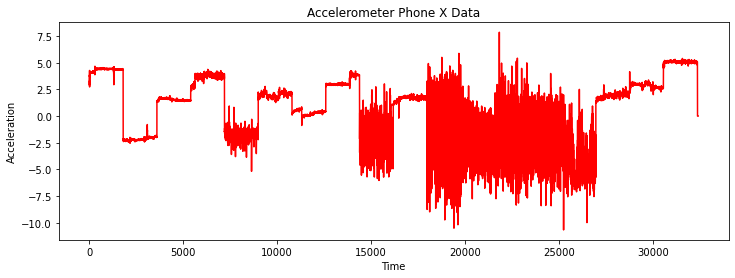

In [58]:
fig = plt.figure(figsize=(12, 4))
plt.plot(X_pad[0].T[0], color='red')
plt.xlabel("Time")
plt.ylabel('Acceleration')
plt.title('Accelerometer Phone X Data')
plt.savefig('X_Accelerometer_Time_Series.png')
plt.show();

## Convert to Numeric Sequence & Pad Sequence

In [45]:
def Label_Prep(data):
    
    master_list = []
    output = []
    label_encoder = LabelEncoder().fit(data[0])
    
    for user in data:
        values_of_seq = np.array(user)
        integer_encoded = label_encoder.transform(values_of_seq)
        master_list.append(integer_encoded)
        
    for item in master_list:
        pad = keras.preprocessing.sequence.pad_sequences(item.reshape(1,item.shape[0]), padding = "post", maxlen = 32409, dtype='int64', value= 18)
        output.append(pad)
    return output

In [46]:
# Now the Labels have been sequenced and padded to the max length 
Y_prep = Label_Prep(Y)

## One Hot Encoding into Sparse Matrices

In [47]:
def OHE(data):
    ohe = OneHotEncoder()
    ohe.fit(data[0].reshape(-1, 1))
    master_list = []
    for user in data:
        sparse_matrix = ohe.transform(user.reshape(-1, 1))
        master_list.append(sparse_matrix)
    return master_list

In [48]:
# Now all of the labels are One Hot Encoded and Ready to be fed into the model!
Y_ohe = OHE(Y_prep)

- Currently, we would have 51 entries with 32409 individual time stamps for each
- Want more indivudal samples
- split each pariticpant into 9 equal in length time series
- 32409/9 = 3601, which is a long enough window of time to capture a change in activity
- Instead of just 51 (one per participant), want to subdivide each person's entry by 9
- 9*51 = 459 => should be the final number of time series entries

In [49]:
def DataParser(data):
    master_list  = []

    for user in data:
        a = 0
        b = 3601
        
        for i in range(9):
            master_list.append(user[a:b])
            a = b
            b += 3601
    return master_list

In [50]:
X_seq = DataParser(X_pad)
print("X Sequence Data Length: ", len(X_seq)) # should equal 459

Y_seq = DataParser(Y_ohe)
print("Y Sequence Data Length: ", len(X_seq))

X Sequence Data Length:  459
Y Sequence Data Length:  459


# Save the Cleaned Data!
- Now that the data has been cleaned and preprocessed, save it in a pickle file for easy recall in the modelling notebook

In [51]:
#X Classifier Data
with open('X_class.pkl','wb') as f:
    pickle.dump(X_class, f)
    
#Y Classifier Data
with open('Y_class.pkl','wb') as f:
    pickle.dump(Y_class_ohe, f)
    
#X Sequence Data
with open('X_seq.pkl','wb') as f:
    pickle.dump(X_seq, f) 
    
#Y Sequence Data
with open('Y_seq.pkl','wb') as f:
    pickle.dump(Y_seq, f)    